<span style="font-size:300% ; font-weight:700">Plankton genomics<span>

The goal of this practical session is to exploit *metagenomics* data collected by Tara Oceans at about 100 stations and extrapolate it to the whole world's ocean. To do so, we will regress the genomic signal on environmental variables (temperature, oxygen, etc.) using *Gradient Boosted Trees*. Since those variables are known at worldwide scale, we will then use the regression model to predict the genomic signal from the environment, everywhere. This process, when applied to species observations, is known as Environmental Niche Modelling or *Habitat Modelling*.

For the purpose of this pratical, we decided to focus on a critical function ensured by phytoplankton in the ocean: *carbon fixation*. Several pathways can fulfill this function, and we decided to focus on some of them : the ones involved in C4 photosynthesis. We therefore selected enzymes known to be involved in carbon concentration mechanisms leading to C4 photosynthesis. As a baseline for photosynthesis, we also selected the RUBISCO, which is likely the most abundant enzyme in the ocean and is involved in every photosynthesis process.

In total, we therefore have 10 enzymes and a measure of their abundance (in standardised number of reads) was calculated through several post-processing steps. An important aspect of those steps is that only relative abundance signal is reliable (i.e. the proportions at each station). The goal is to model the biogeography of these enzymes to explore questions such as: (i) where are certain enzymes/pathways dominant vs others? (ii) where are carbon concentration mechanisms associated with C4 photosynthesis particularly abundant? etc.

# Prepare data

## Import and explore genomic data

Read the `data/reads.csv` file with pandas and explore its content with the `.describe()` method.

Compute the sum of the standardised number of reads per station (for all enzymes: from columns RUBISCO to PEPDK). You can use `.loc` to subset the columns of the DataFrame and the `.sum()` method for a DataFrame to compute the sum. Use `axis=1` to compute the sum per row.

What do you notice about those sums? Do these numbers mean something?

We will study the relative number of reads for each enzyme. To do this, we will divide the number of reads on each row by the row sum. Again, use `.loc` to select the appropriate columns, use the `.div()` method on the DataFrame to perform the division by the vector of row sums you computed just above (and use `axis=1` again to perform the division for each row). Verify that all rows sum to 1 after that.

To visualise were the data was collected, we will plot a map of the sample locations. Slightly modify the example below to plot the longitudes and latitudes of the stations in the `reads` DataFrame.

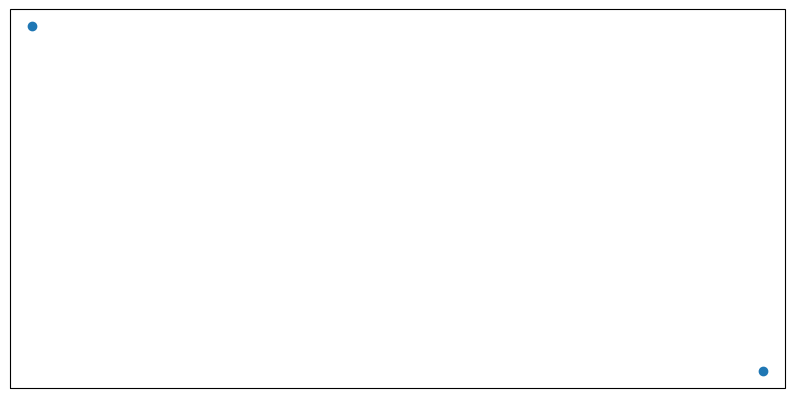

In [5]:
# import modules needed for plotting
import matplotlib.pyplot as plt
# and cartography
import cartopy.crs as ccrs

# Optional: make plots larger in JupyterLab
plt.rcParams['figure.figsize'] = [10, 5]

# define "axes" with a given geographical projection
ax = plt.axes(projection=ccrs.PlateCarree())
# add coastlines
# ax.coastlines()
# add points at given locations
ax.scatter(x=[-170,170], y=[80,-80])
# display the plot
plt.show()

## Import and explore environmental data

As above, read the `data/env.csv` file and explore its content with `.describe()`.

These are complete climatological fields of each variable, at the surface, that span the whole world, on a 1º grid. They come from [World Ocean Atlas](https://www.ncei.noaa.gov/products/world-ocean-atlas); "climatological" means that they are yearly averages, over ~15 years.

To display them we need to convert each variable from its `lon,lat,value` format to a 2D array; the following function does this:

In [8]:
import numpy as np

def prepare_map(lon, lat, values):
    # Reshape data in x,y,z format into coordinates vectors + a 2D array
    # lon, lat : vectors of coordinates
    # value : vector of values (all vectors should be the same length)
    
    # prepare a world-wide grid
    xg = np.arange(-179.5, 179.5, 1)
    yg = np.arange(-89.5, 89.5, 1)
    grid = [{'x':x, 'y':y} for x in xg for y in yg]
    
    # associated provided data to coordinates on the grid
    source_df = pd.DataFrame({'x':lon, 'y':lat, 'z':values})
    grid_df = pd.DataFrame(grid)
    df = grid_df.merge(source_df, how='left', on=['x','y'])
    
    # extract 2D array of the values on the grid
    zg = np.reshape(df.z.values, newshape=(len(yg), len(xg)), order='F')
    
    return(xg, yg, zg)

Now we can use it to draw a worldwide map of a given variable:

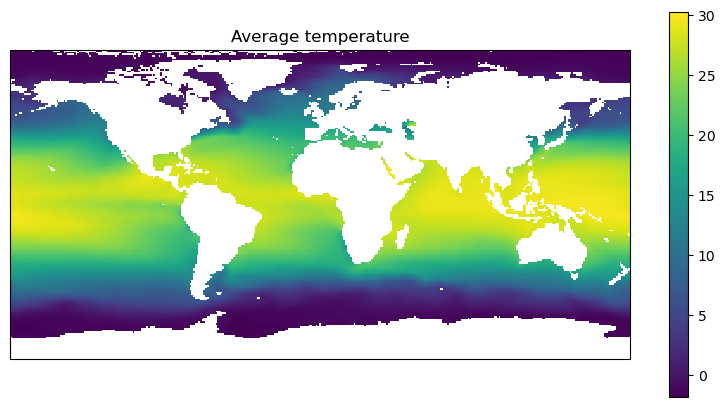

In [9]:
# like before, define "axes" and add coastline
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# reformat the data for the map and plot it as a raster layer
x,y,z = prepare_map(env.lon, env.lat, env.temperature_mean)
layer_temp = ax.pcolormesh(x, y, z)
# add a color scale for that layer
plt.colorbar(layer_temp)
# add a title and display the plot
ax.set_title('Average temperature')
plt.show()

Use this template to plot maps for a few variables.

## Get environmental climatologies for stations

We have point observations of our response variables (the relative number of reads per gene) and world wide observations of potential predictor variables (the environmental climatologies). Now we will associate both to regress the response on the predictors and then, using this model, predict the response variable over the whole world ocean.

In the `reads` DataFrame, modify the coordinates to match with coordinates of the environmental grid: use `np.floor()` to round the longitude values to the nearest lower integer and add 0.5 to match the middle point of the grid cell. Do the same for latitude. Then use the `.merge()` method on the `reads` DataFrame to merge it with the environmental values; save the result as a new DataFrame. We only want to keep the points for which we have both the reads and the environmental data, so we use `how='inner'` (i.e. an "inner" join).

Compare the number of rows before and after the merge. How do you explain the difference?

## Split into train and test sets

We will fit our regression model on a fraction of the data (the "training" set) and then evaluate its performance on a separate, independent fraction, which should never be used to set any aspect of the model (the "test" set). Use `train_test_split()` from `sklearn.model_selection` to set 10% of the stations as a test set, randomly. Verify the size of the train and test sets.

# Single output model with GradientBoostingRegressor

We will start by predicting the relative number of reads for each enzyme independently. This means fitting models with a single response variable, which are much more common and available from many standard modules.

## Simple fit and predict

To fit a Gradient Boosting regression of PEPC on temperature (mean and sd) using he training set, then re-predict the response values, and finally compute some regression scores, we would use:

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

# extract the reponse variable as a numpy array
y_train = reads_train.loc[:,'PEPC'].to_numpy()
# do the same for the predictor variables
X_train = reads_train.loc[:,'temperature_mean':'temperature_sd'].to_numpy()

# define model parameters
# (here, learn a bit more slowly than the default)
params = { 'learning_rate': 0.05 }

# define the model with the parameters above
GBR_model = GradientBoostingRegressor(**params)
# and fit it to the training set
GBR_model.fit(X=X_train, y=y_train)

# now predict the response variable for the training set
y_train_predicted = GBR_model.predict(X_train)

# and compute the regression loss (mean squared error by default)
train_loss = GBR_model._loss(y_train, y_train_predicted)
# and its coefficient of determination
train_R2 = GBR_model.score(X_train, y_train)

# print them with a nice format
print(f"Loss: {train_loss:1.6f}")
print(f"R2: {train_R2:1.2f}")

Loss: 0.001306
R2: 0.84


Using this template, fit a regression of RUBISCO on all environmental variables and evaluate its performance on the training set. Use a learning rate of 0.05, 100 trees, and no limit on the depth of the trees: set `max_depth` to 1000 and `min_sample_leaf` to 1. How good is this model?

Now evalutate the performance on the test set. Do do so, you need to create numpy arrays for the response and predictors in the test set too, apply `.predict()`, and compute `._loss()` and `.score()` on the result. How is the performance looking now? How can you explain this result?

With both the true and predicted values for a given variable several performance metrics can be computed with the functions in `sklearn.metrics()`. Recompute the loss function of the model (which is the mean squared error) and the R2 score. Choose a few other [regression metrics](https://scikit-learn.org/stable/modules/classes.html#regression-metrics); for example compare the R2 and the explained variance.

## Optimise the number of trees

The excellent performance on the training set but poor performance on the test set is a sign of overfitting. A poor performance on both is a sign of underfitting. With gradient boosted regression, an easy hyperparameter to tune to learn enough but not too much is the number of trees. Instead of computing the loss with all 100 trees of the model, we will use the `.staged_predict()` method of the model object to successively predict the test set and compute the loss with the first tree, the first two trees, etc. until 100. Modify the code below to adjust it to your case and then plot the test loss as a function of the number of trees.

```
# initialise an array to store the loss value for the 100 successive predictions
test_loss = np.zeros(100)

# predict with the first, then first+second, etc. trees and compute the loss
# NB: use enumerate() to get the index, i
for i,pred in enumerate(model.staged_predict(X_test)):
    test_loss[i] = model._loss(y_test, pred)
```

This curve is called a "validation curve". According to it, what is a good number of trees, that avoids both under and overfitting? Refit a model with this number of trees and predict the test set. Have the squared error loss and the R2 on the test set improved?

So we have a better model but this is expected: we have just optimized an hyperparameter based on score on the test set, so of course performance improves on this very test set. But this *cheating*. The test set should only be used at the very end, to get an estimate of performance on a never-seen-before dataset. Using the test set for anything else is completely unacceptable.

NB: The approach to build this curve is generalised in the function `sklearn.model_selection.validation_curve`. However, in the particular case of tree-based models, it does not use the fact that trees are cumulative; instead it re-fits a new model for each number of trees so it is considerably slower.

## Cross validate to optimise the number of trees

To get an estimate of performance on an independant dataset but without using the test set, we will further split the training set. And to still use all 82 stations we have for training, we will use k-fold cross validation. To perform 3-fold cross-validation, train a model on each combination of folds, and compute the loss on the validation split, we would use:

```
from sklearn.model_selection import KFold

# prepare the splits
cv = KFold(n_splits=3, shuffle=True, random_state=1)
# NB: shuffle the training set before splitting and use
#     `random_state` for consistency between runs

# for each split
for train,val in cv.split(X_train, y_train):
    # fit a GBR for the training part of this split
    model = GradientBoostingRegressor(**params)
    model.fit(X_train[train], y_train[train])
    
    # predict on the validation part of this split
    y_pred = model.predict(X_train[val])
    model._loss(y_train[val], y_pred)
   ```

Now use this a a template to perform 5-fold cross-validation and compute the full validation curve (using `.staged_predict()` as above) for each split. Note that there will now be 5 validation curves. Store them in a 2D numpy array with each curve as a serapate colum; using that in `.plot()` will plot the 5 curves separately, allowing you to compare them.  
NB: Use the same hyperparameters as above: 0.05 learning rate, 100 trees, unlimited max_depth and a minimum of one observation per leaf.

To get a single curve comparable to the one above, compute the average validation curve with `np.mean()` along axis 1 and plot it. What is the optimal number of trees to avoid under and overfitting?

NB: What we performed manully here can be automated, generalised, and parallelised with the function `sklearn.model_selection.cross_validate()`. The caveat here is that it treats the number of trees as just another parameter and does not output the full validation curve. It also does not work in the multivariate case below.

## Optimise several hyperparameters through grid search

We will use the same general cross-validation principle to optimise other hyper-parameters, in addition to the number of trees. To do so, we will compute the validation curve for different values of learning rate and minumum number of samples per leaf. To do so, create a dictionary of the parameters but, intead of having a scalar value per parameter, provide a list for each. Then this dictionary can be fed to `sklearn.model_selection.ParameterGrid` and be iterated over in a for loop, like so

```
from sklearn.model_selection import ParameterGrid

grid = {
    'n_estimators': [100],
    'max_depth': [1000],
    'learning_rate': [0.5, 0.1],
    'min_samples_leaf': [1, 4]
}

for params in ParameterGrid(grid):
    print(params)
    # do something, like compute the validation curve
```

Use this template to test different values for the `learning_rate` (e.g. 0.05, 0.025, 0.01, 0.005; learning more slowly should result in a better fit and slower overfitting) and for `min_sample_leaf` (e.g. 1, 4, 8, 16; increasing the number of samples per leaf should reduce overfitting and increase the generalisation of the model). Since we will use lower learning rates, you should increase the number of trees (`n_estimators`) to make sure we learn enough; use 1000 for example. `max_depth` should stay not limiting (e.g. 1000).

Create an empty list and, at each turn o the loop, store a new element in that list (with `.append()`) containing the parameters and the validation curves.

Now, using the list computed above, plot all validation curves. If you plot each element in a `for` loop, `plt.plot()` will automatically create each curve with a new color. You can use the `label` argument in `plt.plot()` and add the `plt.legend()` command to create a legend with the hyperparameter values.  
There will be 16 curves (4 learning rates and 4 minimum number of samples per leaf), so a single plot may be difficult to read. You can use several plots or `plt.subplots()` to create separate panels for the different values of `min_sample_leaf` for example.

What is the optimal combination of hyperparameters (`learning_rate`, `min_sample_leaf`, and `n_estimators`)?

Refit a model to the whole training set with the best set of parameters and compute its R2 score on the test set (now that we have our final model, we can use the test set!).

Extract the predictors as a numpy array from the full environment DataFrame (the one with 40404 rows). Use this in `.predict()` to predict the relative number of reads of RUBISCO over the whole world. Use the `prepare_map()` function above and `pcolormesh()` to produce a worldwide map of our prediction. Where is RUBISCO predicted to be most dominant compared to carbon concentration enzymes (remember, we are studying number of reads in relative terms)?

NB: Again, the general principle of the approach presented here is implementd, generalised, and paralelised in `sklearn.model_selection.GridSearchCV`.

# Multioutput model with MBTR

Because the response is relative, a high value for one enzyme implies low values in others. To exploit this covariance among the response variables, it is more appropriate to use an explicitly multioutput regression. For gradient boosted trees, this is implemented in the [Multivariate Boosted TRee (MBTR) module](https://mbtr.readthedocs.io/en/latest/).

Start by extracting the responses and predictors as numpy arrays from the train and test DataFrame. Use the `.loc()` method to select the columns (for the response, we now use all columns from RUBISCO to PEPDK) and use `.to_numpy()` on the result.

## Cross validate

The fitting process is very similar to the `GradientBoostingRegressor` we used above, except that there is no `.staged_predict()` method. Instead the `.predict()` method takes the number of trees to use as the argument `n`. For example, to fit a model and compute the "validation" curve on the test set:

 48%|████▊     | 24/50 [00:27<00:29,  1.13s/it]


#---------------- Model fitted in 4.54e-01 min ----------------


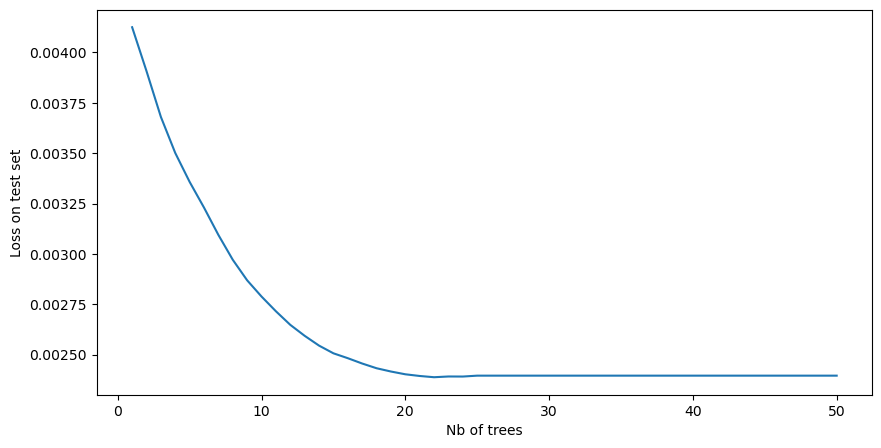

In [29]:
from mbtr.mbtr import MBT
from sklearn import metrics

# define hyperparameters
params = {
    'n_boosts' : 50,              # = number of trees
    'learning_rate' : 0.05,
    'min_leaf' : 1,
    # do not use regularisation (set to ~0)
    'lambda_weights' : 0.001,     
    'lambda_leaves' : 0.001,
    # Use early stopping: stop training when loss on the training
    # set did not improve for 10 trees.
    # Set to a value >= to `n_boosts` to disable
    'early_stopping_rounds' : 10
}

# initialise and fit model
MBT_model = MBT(**params)
MBT_model.fit(X_train, Y_train)

# compute loss curve (on the test set)
# NB: remember that setting hyperparameters based on the test set is BAD!
test_loss = np.zeros(params['n_boosts'])
for i in range(params['n_boosts']):
    Y_test_pred = MBT_model.predict(X_test, n=i+1)
    test_loss[i] = metrics.mean_squared_error(Y_test, Y_test_pred)
    
# plot it
n_trees = np.arange(1, params['n_boosts']+1)
fig,ax = plt.subplots()
ax.plot(n_trees, test_loss)
ax.set_xlabel('Nb of trees')
ax.set_ylabel('Loss on test set')
plt.show()

Following this example and the code you wrote above, compute the average validation curve through 5-fold cross-validation.

## Grid search

Now perform a grid search for hyperparameters `learning_rate` and `min_leaf`, following the examples above. You can reduce the number of cross-validations folds and the number of values on the grid, for speed puroposes.

Plot validation curves and choose the best set of hyperparameters.

## Final predictions

Now, refit the model on the full training set with the best hyperparameters (remember to disable early stopping to make sure to train until the chosen number of trees), predict the test set and compute the R2, finally, predict the world map and plot it for each enzyme.

# Further exercises

## Multiple single-output fits

Instead of one multi-output model, we could have performed several single-output ones using `GradientBoostingRegressor`. Through a grid search, select hyperparameters that limit overfitting to a minimum on one output enzyme of your choosing (you can use `subsample`<1, such as 0.75 or 0.5 to limit overfitting more than we did above). Then fit each enzyme in turn with those hyperparameters, checking that the model indeed did not overfit by computing the validation curve on the test set. Predict the distribution of each enzyme over the whole world. Per pixel, compute the sum of the predicted proportion of each enzyme. What is the problem? Check this sum on the output of MBTR. Is that better?

## Different gradient boosting modules

Beyond `GradientBoostingRegressor` from scikit-learn, we could have used other Python modules dedicated to gradient boosting. The two most well known are [XGBoost](https://xgboost.readthedocs.io) and [LightGBM](https://lightgbm.readthedocs.io). Both are faster and more versatile than the scikit-learn implementation. Try installing one and fitting a single-output regression with them, using cross-validation, grid search etc. You should be able to reuse most of the code written above.

# Reproducibility

To reproduce the computing environment used here, perform the following steps

1.  install an Anaconda distribution (miniconda is fine)

2.  create and activate a new conda environment

```
conda create --name ml4oceans
conda activate ml4oceans
```

3.  install usual packages, distributed through conda

```
# jupyterlab for the interface
conda install -c conda-forge jupyterlab 
# pandas and scikit-learn for computation
conda install -c conda-forge pandas scikit-learn
# matplotlib and cartopy for plotting
conda install -c conda-forge matplotlib cartopy
```

4.  download, modify, and install MBTR

```
# download from github
wget https://github.com/supsi-dacd-isaac/mbtr/archive/refs/tags/v0.1.3.zip
unzip v0.1.3.zip
cd mbtr-master

# modify for compatibility with Python 3.10
sed '325 s/./#&/' -i mbtr/mbtr.py
sed '326 s/./#&/' -i mbtr/mbtr.py

# modify to keep all trees (and not just the best ones)
sed '476 s/./#&/' -i mbtr/mbtr.py

# install
pip install .
```

5.  run JupyterLab
```
jupyter-lab
``` 

    and open the `.ipynb` file.